[Previously](https://madhatter106.github.io/DataScienceCorner/posts/bayesian-approach-to-chlorophyll-estimation-from-satellite-remote-sensing/), I implemented the bayesian version of the OC4 empirical chlorophyll algorithm, where the input consists of the log of the ratio of the maximum of three blue bands to a green band.
Here I will focus on the OC4 algorithm, part of the OCx family of empirical algorithms, which are  generally expressed as follows.
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

However, some diagnostics of the model results suggested that a $4^{th}$ order polynomial may be too complex.
This post is about *model comparison* , which I illustrate by pitting [last post's](https://madhatter106.github.io/DataScienceCorner/posts/bayesian-approach-to-chlorophyll-estimation-from-satellite-remote-sensing/) model against a simpler $3^{rd}$ order polynomial regression in an attempt. Some of the concepts I apply include posterior predictive checks on training as well as out-of-sample data, information criteria measures, and bayes factor.
<!--TEASER_END-->

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
from scipy.stats import norm
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
import pickle
from sklearn.metrics import mean_squared_error, r2_score
from theano import shared

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
%matplotlib inline

In [94]:
## HELPER FUNCTIONS
# ---------------------------------------------------

def FitPoly(X,y, order=4, lin=False):
    """
    Numpy regression. Returns coeffs.
    kwargs:
        lin: specifies whether data is log transformed. Data is log transformed if not."""
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs[::-1]

def GetPPC(data, mcChain, pmModel, varname):
    ppcTrain = pm.sample_ppc(mcChain, samples=1000, model=pmModel)
    # sample posterior predictive check for 50% and 95% density interval
    idx = np.argsort(data)
    sig0 = pm.hpd(ppcTrain[varname], alpha=0.5)[idx] 
    sig1 = pm.hpd(ppcTrain[varname], alpha=0.05)[idx]
    return sig0, sig1

def PlotPPC(data, chlObs, sig0, sig1, bayesCoeffs, oc4V6Coeffs=[], myOLS_coeffs=[],
           title='PPC', ax=None, legendOn=True, xlblOn=True, ylblOn=True, groupIdx=None):
    idx = np.argsort(data)
    data_ord = data[idx]
    dataMock = np.linspace(data.min(), data.max(), 100)
    chlBayes=0
    for i,coeff in enumerate(bayesCoeffs):
        if groupIdx is None:
            chlBayes += coeff * data_ord ** i
        else:
            chlBayes += coeff[groupIdx]
    
    if not ax:
        f,ax = pl.subplots(figsize=(16,10))
    ax.fill_between(data_ord, sig0[:,0], sig0[:,1], color='k', alpha=1, label='50% HPD.')
    ax.fill_between(data_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% HDP')
    ax.plot(data, chlObs, 'ko', alpha=0.5, markeredgecolor='k',  label='Observation')
    if len(oc4V6Coeffs)>0:
        oc4V6Modl=0
        for i, coef in enumerate(oc4V6Coeffs):
            oc4V6Modl += coef * dataMock**i
        ax.plot(dataMock, oc4V6Modl,'r', linewidth=3, linestyle='--', label='OC4v6')
    if len(myOLS_coeffs)>0:
        olsMdl=0
        for i,coeff in enumerate(myOLS_coeffs[::-1]):
            olsMdl+= coeff * dataMock**i
        pl.plot(dataMock, olsMdl,'m', linewidth=5, label='OLS')
    ax.plot(data_ord, chlBayes,'b', linewidth=2, label='Bayesian Regression Mean')
    if xlblOn:
        ax.set_xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
    if ylblOn:
        ax.set_ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
    if legendOn:
        ax.legend(fontsize=14);
    ax.set_title(title);
    return pl.gca()

In [3]:
dfcomp_plot_leg_lbls=['in-sample deviance', 'best waic', 'waic','diff. to best model']

In [4]:
dfNomadV2 = pd.read_pickle('./bayesianChl_DATA/NOMADV2SWFClean.pkl')

In [5]:
dfNomadV2.columns

Index(['id', 'depth', 'rrs411', 'rrs443', 'rrs489', 'rrs510', 'rrs555',
       'rrs670', 'hplc_chl', 'fluo_chl', 'chl_all'],
      dtype='object')

In [6]:
dfNomadV2['chl_type'] = np.where(dfNomadV2.hplc_chl.isnull(),'fluor','hplc')
dfNomadV2.chl_type = dfNomadV2.chl_type.astype('category')

In [8]:
blues = ['rrs443', 'rrs489', 'rrs510']
dfNomadV2['maxBlue'] = dfNomadV2[blues].max(axis=1)
dfNomadV2['maxBlueId'] = dfNomadV2[blues].idxmax(axis=1)
dfNomadV2['blue2green'] = dfNomadV2.maxBlue / dfNomadV2.rrs555
dfLogOCx = pd.DataFrame(columns=['id','mxBl2Gr', 'chl',])
dfLogOCx['id'] = dfNomadV2.id
dfLogOCx['mxBl2Gr'] = np.log10(dfNomadV2.blue2green.values)
dfLogOCx['chl'] = np.log10(dfNomadV2.chl_all.values)
# chl_type codes, 0: fluo, 1: hplc
dfLogOCx['chl_id'] = dfNomadV2.chl_type
dfLogOCx['chl_cat'] = dfNomadV2.chl_type.cat.codes
dfNomadV2.maxBlueCat = dfNomadV2.maxBlueId.astype('category')
dfLogOCx['maxBlue_id'] = dfNomadV2.maxBlueId
dfLogOCx['maxBlue_cat'] = dfNomadV2.maxBlueCat.cat.codes

And let's inspect the data again

In [9]:
dfLogOCx.info(),dfLogOCx.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 7 columns):
id             1016 non-null int32
mxBl2Gr        1016 non-null float64
chl            1016 non-null float64
chl_id         1016 non-null category
chl_cat        1016 non-null int8
maxBlue_id     1016 non-null object
maxBlue_cat    1016 non-null int8
dtypes: category(1), float64(2), int32(1), int8(2), object(1)
memory usage: 38.8+ KB


(None,                 id      mxBl2Gr          chl      chl_cat  maxBlue_cat
 count  1016.000000  1016.000000  1016.000000  1016.000000  1016.000000
 mean   4598.373031     0.117382     0.089204     0.410433     1.297244
 std    2318.827769     0.287944     0.702093     0.492155     0.802847
 min    1441.000000    -0.353183    -1.769551     0.000000     0.000000
 25%    2118.750000    -0.087723    -0.456596     0.000000     1.000000
 50%    3702.500000     0.021409     0.068000     0.000000     2.000000
 75%    7036.250000     0.255020     0.574263     1.000000     2.000000
 max    7831.000000     0.982648     1.891341     1.000000     2.000000)

In [10]:
dfLogOCx.head()

,id,mxBl2Gr,chl,chl_id,chl_cat,maxBlue_id,maxBlue_cat
0,1565,-0.267867,1.581950,fluor,0,rrs510,2
1,1566,-0.220457,1.544192,fluor,0,rrs510,2
2,1567,-0.268537,1.429914,fluor,0,rrs510,2
3,1568,-0.279976,1.680879,fluor,0,rrs510,2
4,1559,-0.167733,1.371991,fluor,0,rrs510,2


As a reminder, the data look like so...

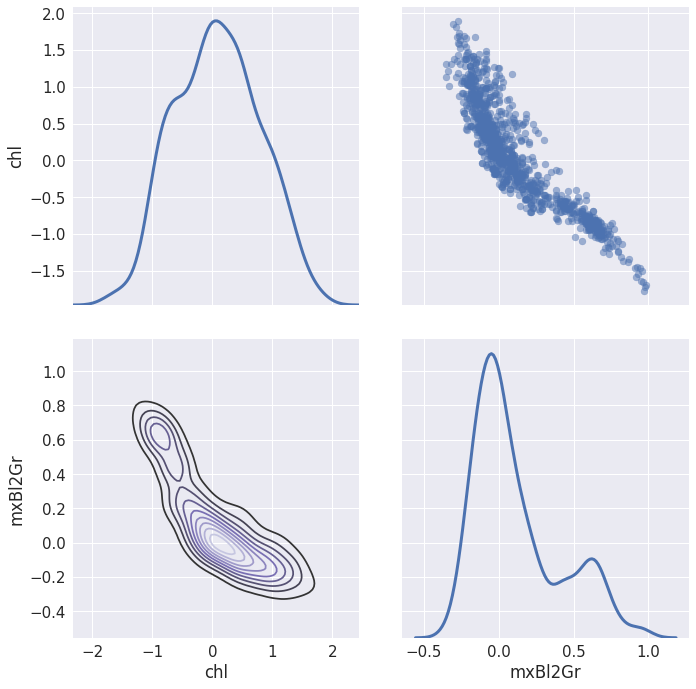

In [11]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOCx, vars=['chl', 'mxBl2Gr'],size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot, cmap="Purples_d");

I'll compute OLS coefficients for polynomials of degree 3 and 4 for reference. Note that I define X_train, y_train here as well, this is in contrast to the testing data that I will later assign to X_test and y_test

In [12]:
X_train = dfLogOCx.mxBl2Gr.values
y_train = dfLogOCx.chl.values
ols3 = FitPoly(X_train, y_train, order=3, lin=False)
ols4 = FitPoly(X_train, y_train, order=4, lin=False)

Bayesian linear regression.
For now, I am simply going to assume I'm still looking for a $4^{th}$ order polynomial. Model comparison will be the subject of a subsequent post.
First I have to specify some priors around the coefficients. I'll assume weakly informative gaussian priors. Before deciding an appropriate distribution for the likelihood, I will check the normality of the  data by way of a normality plot, as well as a comparison between the cummulative distribution function (CDF) of the data and a normal standard distribution.

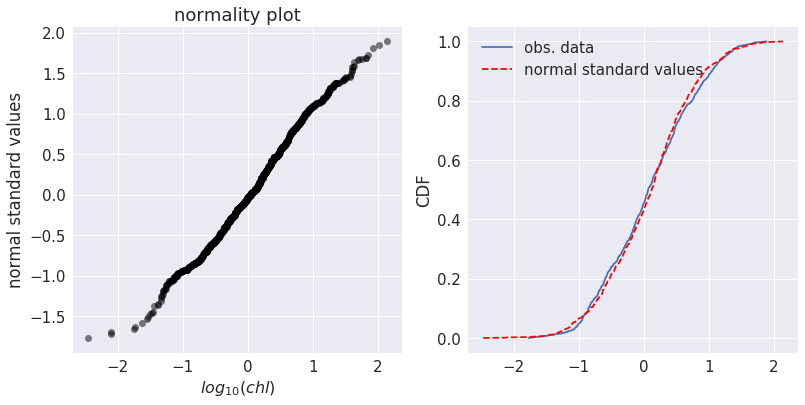

In [13]:
normData = norm.rvs(y_train.mean() ,y_train.std(),
                    size=y_train.size)
normDataSort = np.sort(normData)
logChlSort = np.sort(y_train)
f,ax = pl.subplots(ncols=2,figsize=(13,6))
lbl = r'$log_{10}(chl)$'
ax[0].plot(normDataSort, logChlSort,'ko', alpha=0.5)
ax[0].set_xlabel('%s' %lbl, fontsize=16)
ax[0].set_ylabel('normal standard values');
ax[0].set_title('normality plot')
ax[1].plot(logChlSort, np.linspace(0,1,logChlSort.size), label='obs. data')
ax[1].plot(normDataSort,np.linspace(0,1,normDataSort.size),'r--', 
          label='normal standard values')
ax[1].set_ylabel('CDF')
ax[1].legend(loc='best');

The above suggests that a normal distribution might be a good candidate to apply to the likelihood.
Next is to setup the bayesian model. I'll do the fourth order first and then third order. Note how the input data is cast as a [theano shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables).  This is not necessary to run the model below. I'll revisit why I do this later when I start playing with the model.

The [Kruschke](http://doingbayesiandataanalysis.blogspot.se/2013/10/diagrams-for-hierarchical-models-we.html) diagram for both O(3) and O(4) models is shown below for illustration:


<img src="./bayesianChl_stuff/ocx_34.png", width=650, height=600>

In [14]:
X_Shrd = shared(X_train)

In [76]:
with pm.Model() as OC4_ord4:
    a0_4 = pm.Normal('a0_4', mu=0, sd=10)
    a1_4 = pm.Normal('a1_4', mu=0, sd=10)
    a2_4 = pm.Normal('a2_4', mu=0, sd=10)
    a3_4 = pm.Normal('a3_4', mu=0, sd=10)
    a4_4 = pm.Normal('a4_4', mu=0, sd=10)
    epsilon_4 = pm.HalfNormal('epsilon_4', sd=5)
    mu_4 = a0_4 + a1_4 * X_Shrd + a2_4 * X_Shrd**2 + a3_4 * X_Shrd**3 + a4_4 * X_Shrd**4
    chlPred_4 = pm.Normal('chlPred_4', mu=mu_4, sd=epsilon_4, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord4 = pm.sample(2000, tune=1000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 203.237244
         Iterations: 17
         Function evaluations: 26
         Gradient evaluations: 26


100%|██████████| 3000/3000 [00:25<00:00, 115.66it/s]


In [77]:
with pm.Model() as OC4_ord4_reg:
    a0_4 = pm.Normal('a0_4', mu=0, sd=1)
    a1_4 = pm.Normal('a1_4', mu=0, sd=1)
    a2_4 = pm.Normal('a2_4', mu=0, sd=1)
    a3_4 = pm.Normal('a3_4', mu=0, sd=1)
    a4_4 = pm.Normal('a4_4', mu=0, sd=1)
    epsilon_4 = pm.HalfNormal('epsilon_4', sd=5)
    mu_4 = a0_4 + a1_4 * X_Shrd + a2_4 * X_Shrd**2 + a3_4 * X_Shrd**3 + a4_4 * X_Shrd**4
    chlPred_4 = pm.Normal('chlPred_4', mu=mu_4, sd=epsilon_4, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord4_reg = pm.sample(2000, tune=1000, step=step, start=start)

INFO (theano.gof.compilelock): Refreshing lock /home/madhatter106/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.4-64/lock_dir/lock


Optimization terminated successfully.
         Current function value: 202.179413
         Iterations: 18
         Function evaluations: 27
         Gradient evaluations: 27


100%|██████████| 3000/3000 [00:19<00:00, 155.91it/s]


In [78]:
with pm.Model() as OC4_ord3:
    a0_3 = pm.Normal('a0_3', mu=0, sd=10)
    a1_3 = pm.Normal('a1_3', mu=0, sd=10)
    a2_3 = pm.Normal('a2_3', mu=0, sd=10)
    a3_3 = pm.Normal('a3_3', mu=0, sd=10)
    epsilon_3 = pm.HalfNormal('epsilon_3', sd=5)
    mu_3 = a0_3 + a1_3 * X_Shrd + a2_3 * X_Shrd**2 + a3_3 * X_Shrd**3
    chlPred_3 = pm.Normal('chlPred_3', mu=mu_3, sd=epsilon_3, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord3 = pm.sample(2000, tune=1000, step=step, start=start)

Optimization terminated successfully.
         Current function value: 201.375344
         Iterations: 16
         Function evaluations: 25
         Gradient evaluations: 25


100%|██████████| 3000/3000 [00:11<00:00, 265.94it/s]


In [79]:
with pm.Model() as OC4_ord3_reg:
    a0_3 = pm.Normal('a0_3', mu=0, sd=1)
    a1_3 = pm.Normal('a1_3', mu=0, sd=1)
    a2_3 = pm.Normal('a2_3', mu=0, sd=1)
    a3_3 = pm.Normal('a3_3', mu=0, sd=1)
    epsilon_3 = pm.HalfNormal('epsilon_3', 5)
    mu_3 = a0_3 + a1_3 * X_Shrd + a2_3 * X_Shrd**2 + a3_3 * X_Shrd**3
    chlPred_3_reg = pm.Normal('chlPred_3_reg', mu=mu_3, sd=epsilon_3, observed=y_train)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_ord3_reg = pm.sample(2000, tune=1000, step=step, start=start)

INFO (theano.gof.compilelock): Refreshing lock /home/madhatter106/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.4-64/lock_dir/lock


Optimization terminated successfully.
         Current function value: 204.461262
         Iterations: 15
         Function evaluations: 24
         Gradient evaluations: 24


100%|██████████| 3000/3000 [00:10<00:00, 283.08it/s]


#### Parameter covariance

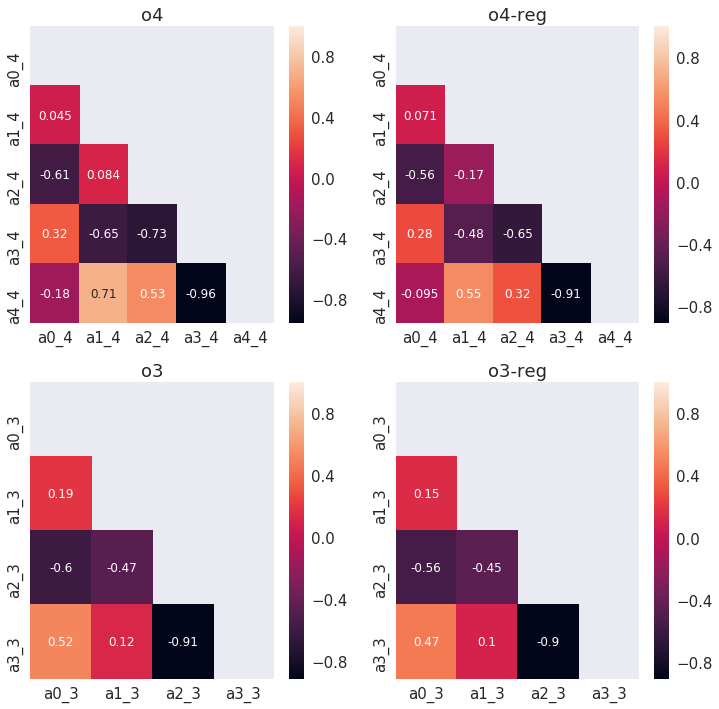

In [81]:
f, ax = pl.subplots(ncols=2, nrows=2, figsize=(12,12))
for axi, trace, nm in zip(ax.ravel(),
                      [trace_ord4, trace_ord4_reg, trace_ord3, trace_ord3_reg],
                      ['o4', 'o4-reg', 'o3', 'o3-reg']):
    varnms = [name for name in trace.varnames if name[0] == 'a']
    dftracecorr = pm.trace_to_dataframe(trace, varnames=varnms).corr() 
    sb.heatmap(dftracecorr, ax=axi, annot=True, annot_kws={'fontsize': 12},
               mask=np.triu(np.ones(dftracecorr.shape), k=0))
    axi.set_title(nm)

In [56]:
def PlotPosteriors(trace, alpha=0.05, refval=None):
    varnms = [nm for nm in trace.varnames if nm[0]=='a']
    axs = pm.plot_posterior(trace, varnames=varnms, ref_val=refval)
    return axs

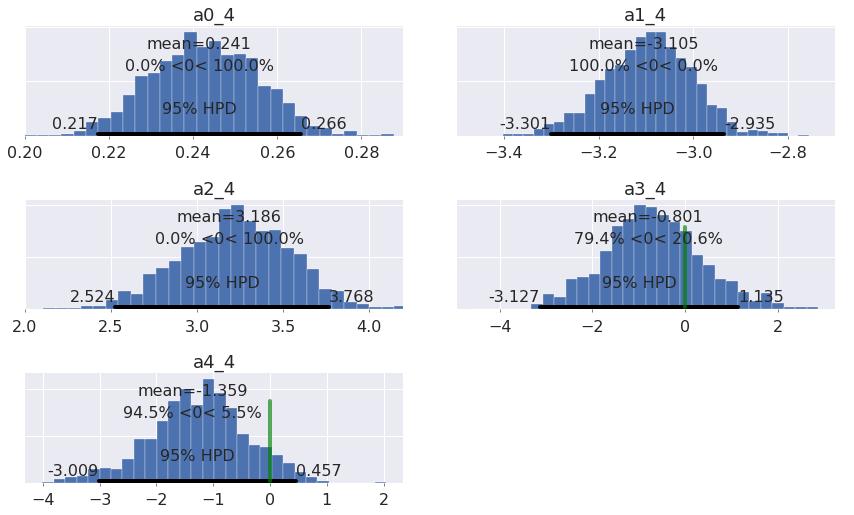

In [82]:
axs = PlotPosteriors(trace_ord4, refval=0)
axs[0].set_xlim((0.2, 0.29));
axs[1].set_xlim((-3.5, -2.7))
axs[2].set_xlim((2, 4.2));

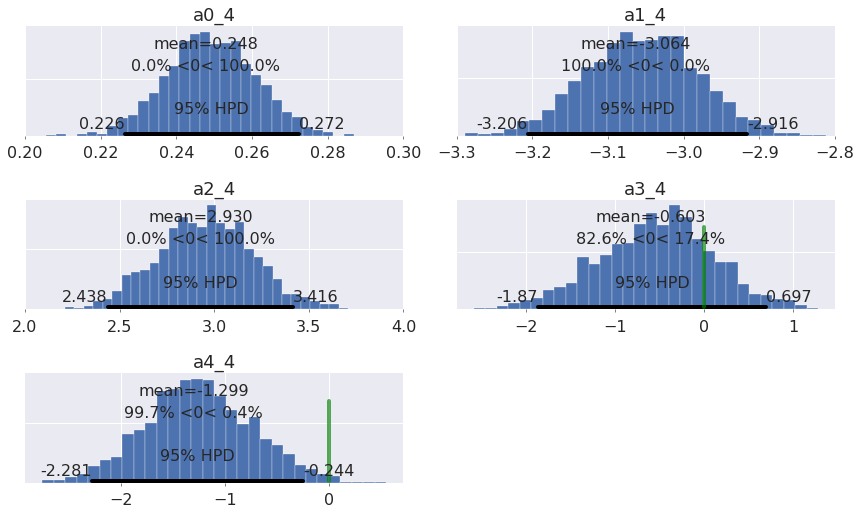

In [85]:
axs = PlotPosteriors(trace_ord4_reg, refval=0)
axs[0].set_xlim((0.20, 0.3))
axs[1].set_xlim((-3.3, -2.8))
axs[2].set_xlim((2, 4));

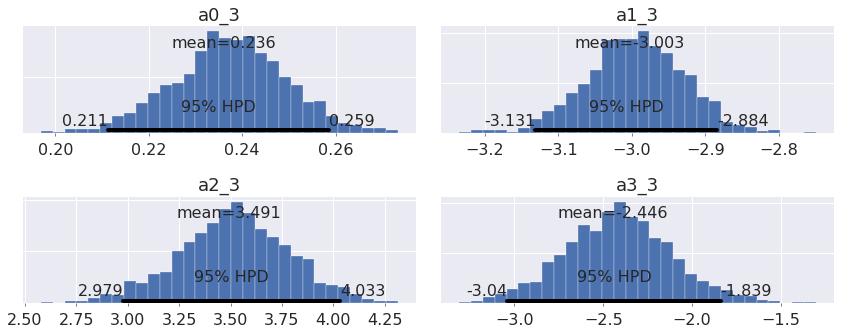

In [86]:
axs = PlotPosteriors(trace_ord3, refval=None)

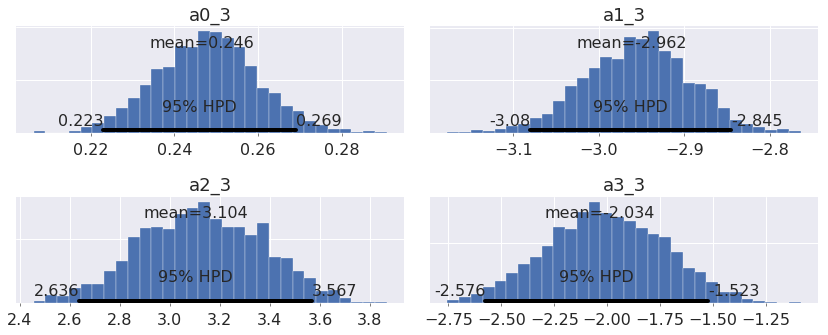

In [88]:
axs = PlotPosteriors(trace_ord3_reg)
#axs[0].set_xlim((0.25, 0.35))
#axs[0]

Note how in the case of the order 4 polynomial regression, a3 and a4 straddle the '0' line with rather wide HDI's. This is not the case with any of the order 3 polynomial regression. 

### Model Comparisons:
The diagnostics I will use here are
* posterior predictive checks on in-sample data
* information criteria; including
    * deviance information criterion
    * widely available information criterion
* posterior predictive checks on out-of-sample data


#### Posterior Predictive Checks on in-sample data

In [89]:
sig0_ord4, sig1_ord4 = GetPPC(data=X_train, mcChain=trace_ord4, pmModel=OC4_ord4, varname='chlPred_4')
bayesCoeffs_ord4 = [trace_ord4['a%d_4' %i].mean() for i in range(5)]

100%|██████████| 1000/1000 [00:00<00:00, 72.36it/s]


In [90]:
sig0_ord4_reg, sig1_ord4_reg = GetPPC(data=X_train, mcChain=trace_ord4_reg, pmModel=OC4_ord4_reg, varname='chlPred_4')
bayesCoeffs_ord4_reg = [trace_ord4_reg['a%d_4' %i].mean() for i in range(5)]

100%|██████████| 1000/1000 [00:00<00:00, 1167.64it/s]


In [91]:
sig0_ord3, sig1_ord3 = GetPPC(data=X_train, mcChain=trace_ord3, pmModel=OC4_ord3, varname='chlPred_3')
bayesCoeffs_ord3 = [trace_ord3['a%d_3' %i].mean() for i in range(4)]

100%|██████████| 1000/1000 [00:00<00:00, 1263.34it/s]


In [92]:
sig0_ord3_reg, sig1_ord3_reg = GetPPC(data=X_train, mcChain=trace_ord3_reg, pmModel=OC4_ord3_reg,
                                      varname='chlPred_3_reg')
bayesCoeffs_ord3_reg = [trace_ord3_reg['a%d_3' %i].mean() for i in range(4)]

100%|██████████| 1000/1000 [00:00<00:00, 1234.56it/s]


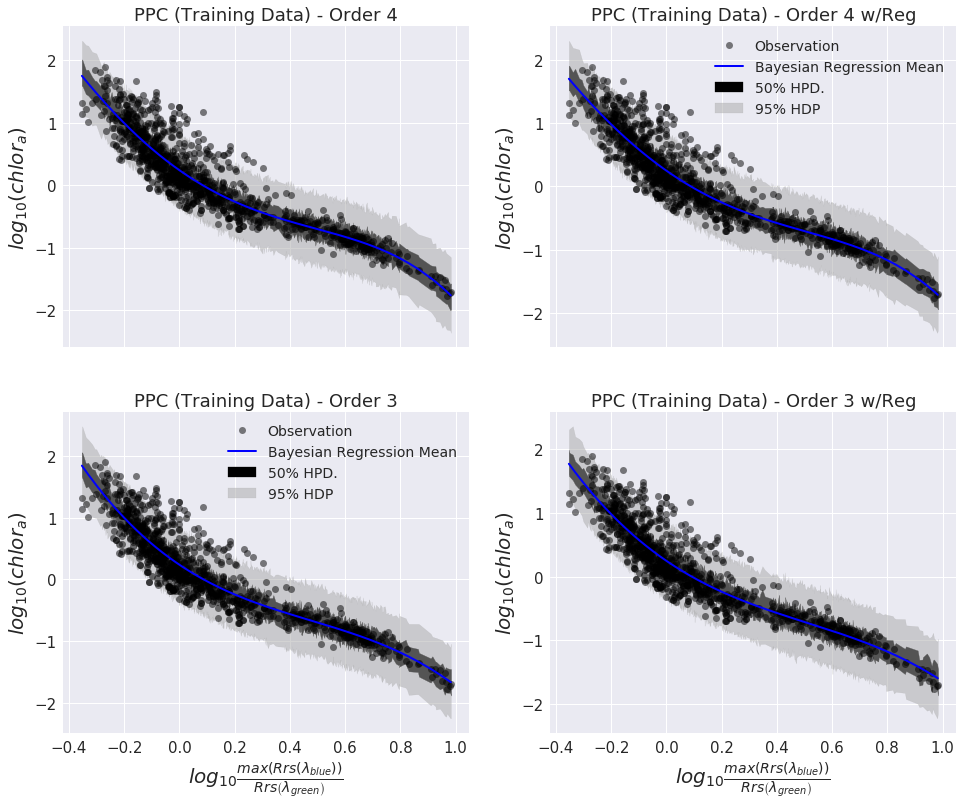

In [98]:
_,axs = pl.subplots(nrows=2,ncols=2, figsize=(16,13), sharex=True)
_ = PlotPPC(X_train, y_train, sig0_ord4, sig1_ord4, bayesCoeffs_ord4,ax=axs[0,0],
            title='PPC (Training Data) - Order 4', xlblOn=False, legendOn=False)
_ = PlotPPC(X_train, y_train, sig0_ord4_reg, sig1_ord4_reg, bayesCoeffs_ord4_reg,ax=axs[0,1],
            title='PPC (Training Data) - Order 4 w/Reg', xlblOn=False)
_ = PlotPPC(X_train, y_train, sig0_ord3, sig1_ord3, bayesCoeffs_ord3,ax=axs[1,0], 
            title='PPC (Training Data) - Order 3')
_ = PlotPPC(X_train, y_train, sig0_ord3_reg, sig1_ord3_reg, bayesCoeffs_ord3_reg,ax=axs[1,1],
            title='PPC (Training Data) - Order 3 w/Reg', legendOn=False)

#### Widely Available Information Criteria (DIC)
* what it is
* how it's calculated
* what it tells us

In [99]:
modlNames = ['o4', 'o4_reg', 'o3', 'o3_reg']
dfComp = pm.compare([trace_ord4, trace_ord4, trace_ord3, trace_ord3_reg],
                   [OC4_ord4, OC4_ord4_reg, OC4_ord3, OC4_ord3_reg])
dfComp.index = [modlNames[i] for i in dfComp.index]
dfComp

INFO (theano.gof.compilelock): Refreshing lock /home/madhatter106/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.4-64/lock_dir/lock


,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
o4,379.578,5.50634,0,0.336696,56.3988,0,0
o4_reg,379.578,5.50634,0,0.336696,56.3988,0,0
o3,380.289,4.61867,0.711159,0.235946,56.6251,0.303433,0
o3_reg,382.202,4.43504,2.62408,0.0906622,55.4651,0.276846,0


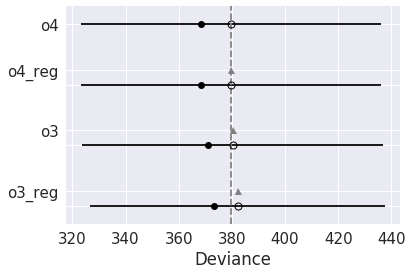

In [100]:
ax = pm.compareplot(dfComp)
ax.set_ylim(-1.1, 0.1);
ax.legend()

### Predicting Outcome from New Data
A machine learning practitioner who what (s)he's doing will want to apply the model to data that has not been used in the fitting process to assess the model's skill in real world predictions. The advantage in this particular case however is that in addition to prediction, we'll get uncertainties, not really available off the shelf with scikit-learn or other machine learning libraries. Even better, we can use the now familiar *posterior predictive checks* approach to do just that. 

As a reminder I framed the input data as a [theano shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables) to allow replacing the training data with the test data. The test data consists in SeaWiFS matchup data that originates, like NOMAD, from [SeaBASS](https://seabass.gsfc.nasa.gov/). However,  the data in this set was gathered after NOMAD was put together (2010 on) to avoid data leakage.

Another interesting aspect of this particular test data set is that because it's a matchup set it contains corresponding in situ and satellite measurements, which makes for an interesting performance comparison of the model.

In [101]:
# load test set
dfTest = pd.read_pickle('./bayesianChl_DATA/dfSwfChloraMups2010p.pkl')
dfTest.info()
dfLogTest = pd.DataFrame(columns=['id','seawifs_mxBl2Gr','insitu_chlor_a', 'seawifs_chlor_a'])
dfLogTest.id = dfTest.id
dfLogTest.seawifs_mxBl2Gr=  np.log10(dfTest.seawifs_mxBl2Gr)
dfLogTest.insitu_chlor_a = np.log10(dfTest.insitu_chlor_a)
dfLogTest.seawifs_chlor_a = np.log10(dfTest.seawifs_chlor_a)
X_test, y_test = dfLogTest.seawifs_mxBl2Gr.values, dfLogTest.insitu_chlor_a.values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
id                   59 non-null int64
latitude             59 non-null float64
longitude            59 non-null float64
date_time            59 non-null datetime64[ns]
cruise               59 non-null object
seawifs_solz         59 non-null float64
seawifs_senz         59 non-null float64
seawifs_windspeed    59 non-null float64
seawifs_tdiff        59 non-null int64
seawifs_mxBl2Gr      59 non-null float64
insitu_chlor_a       59 non-null float64
seawifs_chlor_a      59 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 5.6+ KB


In [102]:
# SUBSTITUTING TRAINING SET FOR TEST SET - CHANGING VALUES HERE WILL ALSO CHANGE VALUES IN THE MODEL
X_Shrd.set_value(X_test)
sig0_3Tst, sig1_3Tst = GetPPC(data=X_test, mcChain=trace_ord3, pmModel=OC4_ord3, varname='chlPred_3')
sig0_3RegTst, sig1_3RegTst = GetPPC(data=X_test, mcChain=trace_ord3_reg, pmModel=OC4_ord3_reg, varname='chlPred_3_reg')
sig0_4Tst, sig1_4Tst = GetPPC(data=X_test, mcChain=trace_ord4, pmModel=OC4_ord4, varname='chlPred_4')
sig0_4TstReg, sig1_4TstReg = GetPPC(data=X_test, mcChain=trace_ord4_reg, pmModel=OC4_ord4_reg, varname='chlPred_4')

100%|██████████| 1000/1000 [00:00<00:00, 1586.23it/s]


In [103]:
bayesCoeffs_3Tst = [trace_ord3['a%d_3' %i].mean() for i in range(4)]
bayesCoeffs_3TstReg = [trace_ord3_reg['a%d_3' %i].mean() for i in range(4)]
bayesCoeffs_4Tst = [trace_ord4['a%d_4' %i].mean() for i in range(5)]
bayesCoeffs_4TstReg = [trace_ord4_reg['a%d_4' %i].mean() for i in range(5)]

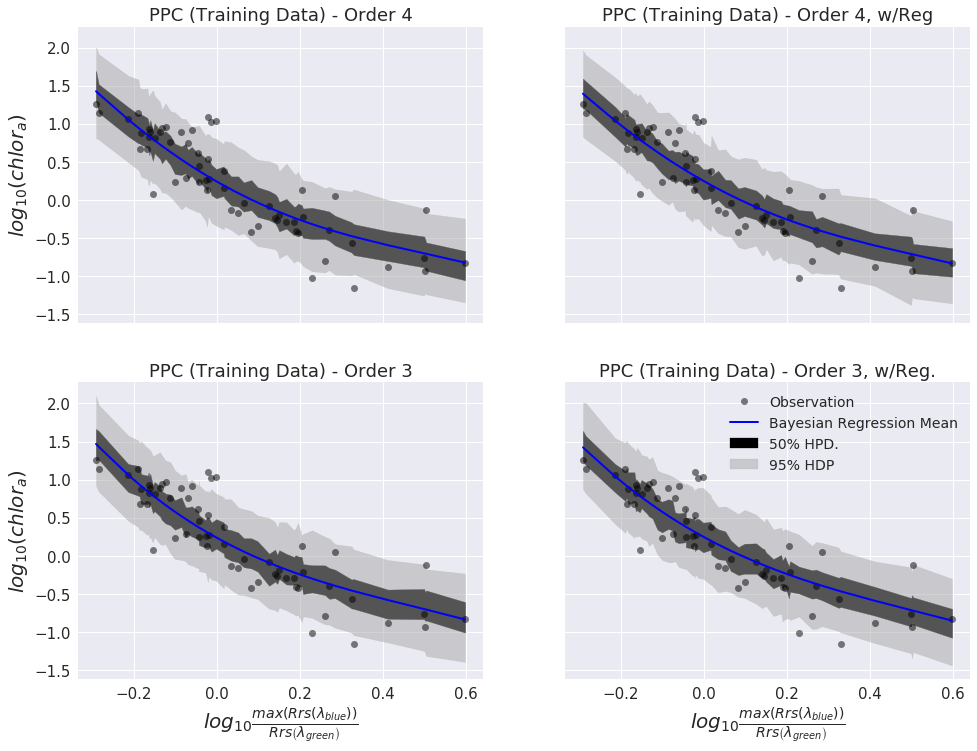

In [107]:
f,axs = pl.subplots(nrows=2, ncols=2, figsize=(16,12),sharex=True, sharey=True)
_ = PlotPPC(X_test, y_test, sig0_4Tst, sig1_4Tst, bayesCoeffs_4Tst, ax=axs[0,0],
            title='PPC (Training Data) - Order 4', legendOn=False, xlblOn=False)
_ = PlotPPC(X_test, y_test, sig0_4TstReg, sig1_4TstReg, bayesCoeffs_4TstReg, ax=axs[0,1],
            title='PPC (Training Data) - Order 4, w/Reg',
           legendOn=False, xlblOn=False, ylblOn=False )
_ = PlotPPC(X_test, y_test, sig0_3Tst, sig1_3Tst, bayesCoeffs_3Tst, ax=axs[1,0],
            title='PPC (Training Data) - Order 3',
           legendOn=False)
_ = PlotPPC(X_test, y_test, sig0_3RegTst, sig1_3RegTst, bayesCoeffs_3TstReg, ax=axs[1,1],
            title='PPC (Training Data) - Order 3, w/Reg.', ylblOn=False)

Similarly to PPCs on in-sample data, the results of PPC on out-of-sample (test) data confirms that the simpler O(3) polynomial regression does not perform much worse than its more complex O(4) counterpart. From a more frequentist point of view, computing MSEs on frequentist OLS and Bayesian forms of both models shows a slight improvement in favor of the simpler, O(3) version.

## Partial Pooling & Hierarchical Bayes

#### Hierarchical O(4) and O(3) Models 

So far the inferences described above carry the implicit assumption that all data are the same, and as such can be pooled to calculate a single regression. This particular dataset may contradict this assumption in two ways. 

The first potential violation concerns the predicted *in-situ* chlorophyll data, which was obtain via one of two methods; hplc or fluorescence. One approach might be to only retain data where chlorophyll is only of one type, e.g. hplc, which is expected to produce more consistent estimates,  and throw out the rest of the data. This is a bad idea because the fluorescence data still carries information, no matter how noisy. Because prediction is the goal of the exercise, the algorithm should be trained with as much data as possible.

The second potential violation is related to the predictor variable. Specifically, band ratio used was computed by selecting the largest of 3 (in this particular example) band ratios. The band selection implies more complexity than what a polynomial regression can handle.

One common way to address these issues is to introduce interaction terms. However this adds undue complication to polynomial regression of order 2 or above. **High-order polynomial regressions are already practically uninterpretable because of the compounding of the predictor variable.** An alternative is to use a hierarchical framework. Here, the introduction of hyperpriors allow similarities between data type to be taken into account, while enabling a category-specific inference to take place.

Below, I address the two partial pooling schemes mentioned above - chlorophyll measurement method and band ratio - separately.

As a reminder, the dataset used here, the first few lines of which are displayed again below, has two columns, *'chl_id'*, and *'maxBlue_id'*. These specify respectively the method by which chlorophyll was measured, and the band selected to compute the ratio, for each particular observation. The inferential framework used here expects numerical input so two more columns, *'chl_cat'* and *'maxBlue_cat'*  contain corresponding integer labels.

In [243]:
dfLogOCx.head()

,id,mxBl2Gr,chl,chl_id,chl_cat,maxBlue_id,maxBlue_cat
0,1565,-0.267867,1.581950,fluor,0,rrs510,2
1,1566,-0.220457,1.544192,fluor,0,rrs510,2
2,1567,-0.268537,1.429914,fluor,0,rrs510,2
3,1568,-0.279976,1.680879,fluor,0,rrs510,2
4,1559,-0.167733,1.371991,fluor,0,rrs510,2


#### Hierarchical model: chlorophyll type

First a quick look the different categories are shown below:

In [246]:
dfLogOCx.chl_id.value_counts(normalize=True)

fluor    0.589567
hplc     0.410433
Name: chl_id, dtype: float64

The above shows the dataset comprising a 59%/41% fluorescence/hplc split; not exactly balanced, but not terribly skewed either

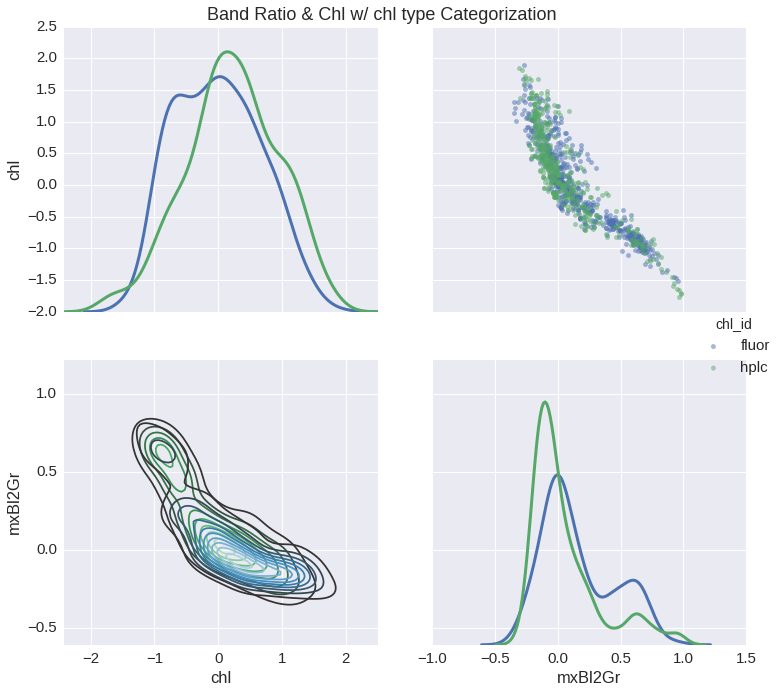

In [255]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOCx, vars=['chl', 'mxBl2Gr'],size=5, diag_sharey=False, hue='chl_id',
               hue_kws={'cmap':["Greens_d", "Blues_d"]});
g = g.map_upper(pl.scatter,alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot);
g.add_legend();
g.fig.suptitle('Band Ratio & Chl w/ chl type Categorization')
g.fig.tight_layout(pad=1.5)

The model formulation is more easily understandable visually. Below is the corresponding [Kruschke](http://doingbayesiandataanalysis.blogspot.se/2013/10/diagrams-for-hierarchical-models-we.html) diagram: 

<img src="./bayesianChl_stuff/ocx_h3r.png", width=650, height=600>

Below I create indices, chl_idx, from the chlorophyll measurement method used for corresponding observations. These I will use to inform the partial pools to which the data belong. The variable numGroups simply contains the number of groups to which the observations are allocated.

In [ ]:
numGroups = dfLogOCx.chl_cat.unique().size
chl_idx = dfLogOCx.chl_cat.values

In [128]:
with pm.Model() as OC4_h4_chl:
    # Hyperpriors
    mu_a0 = pm.Normal('mu_a0', mu=0, sd=10)
    sd_a0 = pm.HalfNormal("sd_a0", sd=10)
    mu_a1 = pm.Normal('mu_a1', mu=0, sd=10)
    sd_a1= pm.HalfNormal('sd_a1', sd=10)
    mu_a2 = pm.Normal('mu_a2', mu=0, sd=10)
    sd_a2 = pm.HalfNormal('sd_a2', sd=10)
    mu_a3 = pm.Normal('mu_a3', mu=0, sd=10)
    sd_a3 = pm.HalfNormal("sd_a3", sd=10)
    mu_a4 = pm.Normal('mu_a4', mu=0, sd=10)
    #Priors
    a0_h4_chl = pm.Normal('a0_h4_chl', mu=mu_a0, sd=sd_a0, shape=numGroups)
    a1_h4_chl = pm.Normal('a1_h4_chl', mu=mu_a1, sd=sd_a1, shape=numGroups)
    a2_h4_chl = pm.Normal('a2_h4_chl', mu=mu_a2, sd=sd_a2, shape=numGroups)
    a3_h4_chl = pm.Normal('a3_h4_chl', mu=mu_a3, sd=sd_a3, shape=numGroups)
    a4_h4_chl = pm.Normal('a4_h4_chl', mu=mu_a4, sd=sd_a4, shape=numGroups)
    
    # Likelihood
    epsilon_h4 = pm.HalfNormal('epsilon_h4', 5)
    mu_h4_chl =  a0_h4_chl[chl_idx] + a1_h4_chl[chl_idx] * X_Shrd * (a2_h4_chl[chl_idx] * X_Shrd +
                                                         a3_h4_chl[chl_idx] * X_Shrd**2 +
                                                         a4_h4_chl[chl_idx] * X_Shrd**3)
    chlPred_h4_chl = pm.Normal('chlPred_h4_chl', mu=mu_h4_chl, sd=epsilon_h4, observed=y_train)
    
    # Sample
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=OC4_h4_chl.dict_to_array(sds)**2, is_cov=True)
    trace_h4_chl = pm.sample(2000, tune=1000, step=step, start=mu)

Average ELBO = -183.05: 100%|██████████| 100000/100000 [00:42<00:00, 2330.35it/s]
Finished [100%]: Average ELBO = -181.28
100%|██████████| 10500/10500 [07:18<00:00, 21.49it/s] 


Below, the results of the inference are displayed, with the coefficients for each category displayed. The index[1] corresponds to fluorescence; the index[2] to hplc.

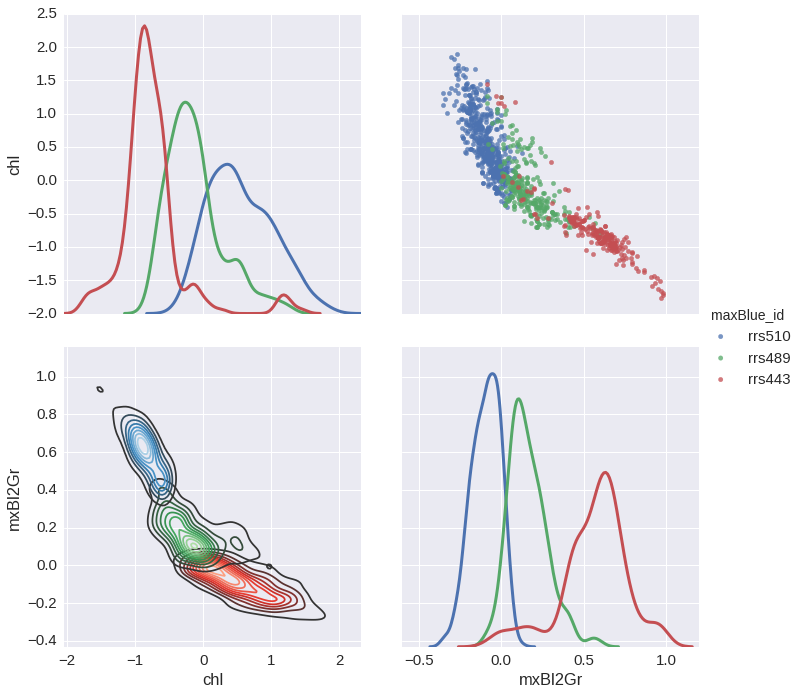

In [162]:
sb.set(font_scale=1.5)
g = sb.PairGrid(dfLogOCx, vars=['chl', 'mxBl2Gr'],size=5, diag_sharey=False, hue='maxBlue_id',
                hue_kws={"cmap": ["Reds_d", "Greens_d", "Blues_d"]});
g = g.map_upper(pl.scatter,alpha=0.75)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot);
g.add_legend();

In [166]:
numGroups = dfLogOCx.maxBlue_cat.unique().size
mxBl_idx = dfLogOCx.maxBlue_cat.values
with pm.Model() as OC4_ho3r_mxBl:
    # Hyperpriors
    mu_a0 = pm.Normal('mu_a0', mu=0, sd=10)
    sd_a0 = pm.HalfNormal("sd_a0", sd=10)
    mu_a1 = pm.Normal('mu_a1', mu=0, sd=10)
    sd_a1= pm.HalfNormal('sd_a1', sd=10)
    mu_a2 = pm.Normal('mu_a2', mu=0, sd=10)
    sd_a2 = pm.HalfNormal('sd_a2', sd=10)
    mu_a3 = pm.Normal('mu_a3', mu=0, sd=10)
    sd_a3 = pm.HalfNormal("sd_a3", sd=10)
    #Priors
    a0_h3r = pm.Normal('a0_h3r', mu=mu_a0, sd=sd_a0, shape=numGroups)
    a1_h3r = pm.Normal('a1_h3r', mu=mu_a1, sd=sd_a1, shape=numGroups)
    a2_h3r = pm.Normal('a2_h3r', mu=mu_a2, sd=sd_a2, shape=numGroups)
    a3_h3r = pm.Normal('a3_h3r', mu=mu_a3, sd=sd_a3, shape=numGroups)
    # Likelihood
    epsilon_h3r = pm.HalfCauchy('epsilon_h3r', 5)
    mu_h3r =  a0_h3r[mxBl_idx] + X_Shrd * (a1_h3r[mxBl_idx] + a2_h3r[mxBl_idx] * X_Shrd +
                                          a3_h3r[mxBl_idx] * X_Shrd**2)
    nu_h3r = pm.Deterministic('nu_h3r',pm.Exponential('nu_h3r_', 1/29) + 1)
    chlPred_h3r = pm.StudentT('chlPred_h3r', mu=mu_h3r, sd=epsilon_h3r, nu=nu_h3r, observed=y_train)
    #start = pm.find_MAP()
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=OC4_ho3r_mxBl.dict_to_array(sds)**2, is_cov=True)
    trace_h3r_mxBl = pm.sample(10000, step=step, start=mu)
    #step = pm.NUTS(scaling=start)
    #trace_h3r = pm.sample(10000, step=step, start=start)

Average ELBO = -205.94: 100%|██████████| 100000/100000 [00:42<00:00, 2337.96it/s]
Finished [100%]: Average ELBO = -205.33
100%|██████████| 10500/10500 [15:20<00:00, 11.41it/s]


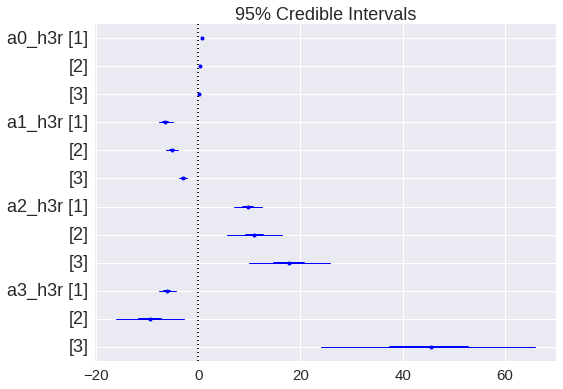

In [180]:
pm.forestplot(trace_h3r_mxBl, varnames=varnames);

Would a piecewise linear regression work better?

In [260]:
with pm.Model() as OC_hierLinRegMxBl:
    # Hyperpriors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sd=10)
    sd_alpha = pm.HalfNormal("sd_alpha", sd=10)
    mu_beta = pm.Normal('mu_beta', mu=0, sd=10)
    sd_beta= pm.HalfNormal('sd_beta', sd=10)
    #Priors
    alpha = pm.Normal('alpha', mu=mu_alpha, sd=sd_alpha, shape=numGroups)
    beta = pm.Normal('beta', mu=mu_beta, sd=sd_beta, shape=numGroups)
    # Likelihood
    epsilon_ = pm.HalfCauchy('epsilon_', 5)
    mu_ =  alpha[mxBl_idx] + X_Shrd * beta[mxBl_idx]
    nu_ = pm.Deterministic('nu_',pm.Exponential('nu_pre', 1/29) + 1)
    chlPredLinReg = pm.StudentT('chlPredLinReg', mu=mu_, sd=epsilon_, nu=nu_, observed=y_train)
    #start = pm.find_MAP()
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=OC_hierLinRegMxBl.dict_to_array(sds)**2, is_cov=True)
    trace_hierLinRegMxBl = pm.sample(10000, step=step, start=mu)

Average ELBO = -198.08: 100%|██████████| 100000/100000 [00:30<00:00, 3253.23it/s]
Finished [100%]: Average ELBO = -198.04
100%|██████████| 10500/10500 [02:25<00:00, 71.93it/s]


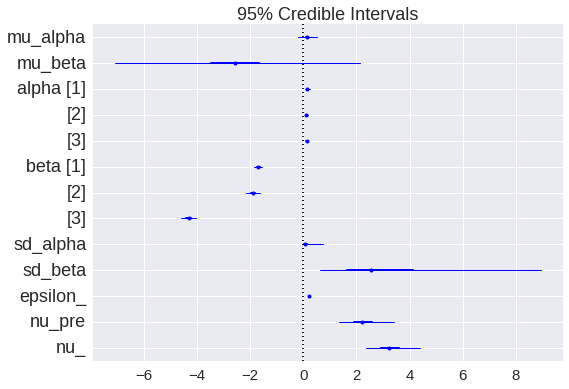

In [261]:
pm.forestplot(trace_hierLinRegMxBl)

In [264]:
# Taking into account max Blue type and in situ chl type

In [ ]:
numMxBlGrp = dfLogOCx.maxBlue_cat.unique().size
mxBlIdx = dfLogOCx.maxBlue_cat.values
numChTypGrp = dfLogOCx.chl_cat.unique().size
chlTypIdx = dfLogOCx.chl_cat.values
with pm.Model() as OC_hierLinRegMxBl:
    # Hyperpriors
    mu_alpha = pm.Normal('mu_alpha', mu=0, sd=10)
    sd_alpha = pm.HalfNormal("sd_alpha", sd=10)
    mu_betaMxBl = pm.Normal('mu_betaMxBl', mu=0, sd=10)
    sd_betaMxBl= pm.HalfNormal('sd_betaMxBl', sd=10)
    mu_betaChlTyp = pm.Normal('mu_betaChlTyp', mu=0, sd=10)
    sd_betaChlTyp = pm.HalfNormal('sd_betChlTyp', sd=10)
    mu_interact = pm.Normal('mu_interact', mu=0, sd=10)
    sd_interact = pm.HalfNormal('sd_interact', sd=10)
    #Priors
    alpham = pm.Normal('alpha', mu=mu_alpha, sd=sd_alpha, shape=numMxBlGrp)
    betaMxBlue = pm.Normal('beta', mu=mu_beta, sd=sd_beta, shape=numMxBlGrp)
    
    # Likelihood
    epsilon_ = pm.HalfCauchy('epsilon_', 5)
    gamma = 
    mu_ =  alpha[mxBl_idx] + X_Shrd * beta[mxBl_idx]
    nu_ = pm.Deterministic('nu_',pm.Exponential('nu_pre', 1/29) + 1)
    chlPredLinReg = pm.StudentT('chlPredLinReg', mu=mu_, sd=epsilon_, nu=nu_, observed=y_train)
    #start = pm.find_MAP()
    mu, sds, elbo = pm.variational.advi(n=100000)
    step = pm.NUTS(scaling=OC_hierLinRegMxBl.dict_to_array(sds)**2, is_cov=True)
    trace_hierLinRegMxBl = pm.sample(10000, step=step, start=mu)

### So which model???

One way is to do some out-of-sample testing.
Within a bayesian framework, an alternative borrowed from information theory, is the Watanabe-Akaike Information Criterion, aka Widely Available Information Criterion or WAIC.

In [262]:
traces = [trace_ord4, trace_ord3, trace_ord3_rob, trace_ord3_reg, trace_h3r, trace_h3r_mxBl, trace_hierLinRegMxBl]
models = [OC4_ord4, OC4_ord3, OC4_ord3_robust, OC4_ord3_reg, OC4_ho3r, OC4_ho3r_mxBl, OC_hierLinRegMxBl]
modNames=['O(4)', 'O(3)', 'O(3)Rob', 'O(3)w/Reg', 'HO(3)Rob_chlTyp', 'HO(3)Rob_mxBl', "PieceWiseLinReg"]
dfComp = pm.compare(traces,models)
oldIdx = dfComp.index.tolist()
dfComp.index = [modNames[i] for i in oldIdx]
dfComp

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
HO(3)Rob_mxBl,243.11,17.7915,0,0.999155,61.9269,0,1
HO(3)Rob_chlTyp,257.261,9.05952,14.1507,0.000845001,67.357,22.7639,0
O(3)Rob,289.524,5.96153,46.4139,8.33664e-11,66.9552,20.2376,0
PieceWiseLinReg,329.391,8.37525,86.2804,1.83686e-19,64.2139,20.5247,0
O(4),379.521,5.5421,136.411,2.38966e-30,56.4189,32.9002,0
O(3),380.424,4.76178,137.314,1.52178e-30,56.5828,34.3666,0
O(3)w/Reg,398.05,4.28746,154.94,2.2643e-34,53.3532,34.7207,0


In [263]:
dfComp.loc[:,['WAIC', 'weight']]

,WAIC,weight
HO(3)Rob_mxBl,243.11,0.999155
HO(3)Rob_chlTyp,257.261,0.000845001
O(3)Rob,289.524,8.33664e-11
PieceWiseLinReg,329.391,1.83686e-19
O(4),379.521,2.38966e-30
O(3),380.424,1.52178e-30
O(3)w/Reg,398.05,2.2643e-34


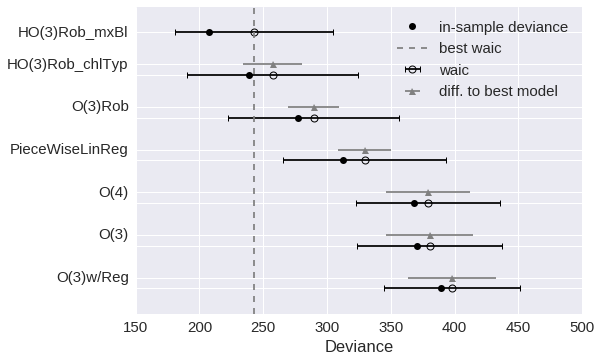

In [265]:
ax = pm.compareplot(dfComp)
ax.set_ylim(-1.1, 0.1)
ax.legend(dfcomp_plot_leg_lbls);

In [199]:
chain_ho3r = trace_h3r[1000:]
sig0_hord3r, sig1_hord3r = GetPPC(data=X_train, mcChain=chain_ho3r, pmModel=OC4_ho3r, varname='chlPred_h3r')
bayesCoeffs_hord3r = [chain_ho3r['a%d_h3r' %i].mean(axis=0) for i in range(4)]

100%|██████████| 1000/1000 [00:01<00:00, 623.58it/s]


In [231]:
bayesCoeffs_h2ord3r = [chain_h2o3r['a%d_h3r' %i].mean(axis=0) for i in range(4)]

In [236]:
for coeffs in bayesCoeffs_h2ord3r:
    print(coeffs[np.random.choice([0,1,2])])

0.119656320808
-6.3967195832
10.9604920792
-6.02442891473


In [234]:
bayesCoeffs_h2ord3r

[array([ 0.78828842,  0.31310078,  0.11965632]),
 array([-6.39671958, -5.05110623, -2.88814343]),
 array([  9.77429178,  10.96049208,  17.75958865]),
 array([ -6.02442891,  -9.36063408,  45.05327998])]

In [210]:
chain_h2o3r = trace_h3r_mxBl[1000:]
sig0_h2ord3r, sig1_h2ord3r = GetPPC(data=X_train, mcChain=chain_h2o3r, pmModel=OC4_ho3r_mxBl, varname='chlPred_h3r')
bayesCoeffs_h2ord3r = [chain_h2o3r['a%d_h3r' %i].mean(axis=0) for i in range(4)]

100%|██████████| 1000/1000 [00:01<00:00, 546.08it/s]


TypeError: PlotPPC() got an unexpected keyword argument 'groupIdx'

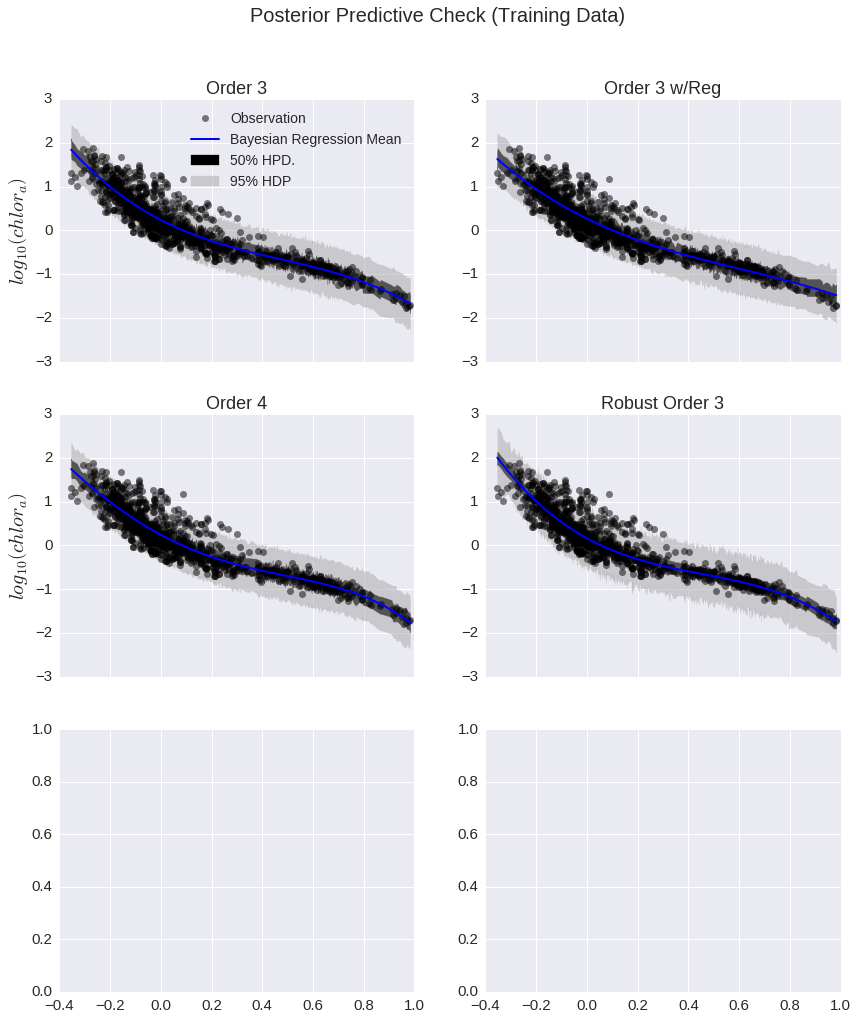

In [240]:
f,axs = pl.subplots(nrows=3,ncols=2, figsize=(14,16), sharex=True)
f.suptitle('Posterior Predictive Check (Training Data)', fontsize=20)
_ = PlotPPC(X_train, y_train, sig0_ord3, sig1_ord3, bayesCoeffs_ord3,ax=axs[0, 0], 
            title='Order 3', xlblOn=False,)
_ = PlotPPC(X_train, y_train, sig0_ord4, sig1_ord4, bayesCoeffs_ord4,ax=axs[1, 0],
            title='Order 4', legendOn=False, xlblOn=False)
_ = PlotPPC(X_train, y_train, sig0_ord3_reg, sig1_ord3_reg, bayesCoeffs_ord3_reg,ax=axs[0, 1],
            title='Order 3 w/Reg', legendOn=False, xlblOn=False, ylblOn=False)
_ = PlotPPC(X_train, y_train, sig0_ord3r, sig1_ord3r, bayesCoeffs_ord3r,ax=axs[1, 1],
            title='Robust Order 3', legendOn=False, xlblOn=False, ylblOn=False)
_ = PlotPPC(X_train, y_train, sig0_hord3r, sig1_hord3r, bayesCoeffs_hord3r, ax=axs[2,0],
           legendOn=False, title='Hierarchical Robust Order 3 - Chl. Type', groupIdx=chl_idx)
_ = PlotPPC(X_train, y_train, sig0_h2ord3r, sig1_h2ord3r, bayesCoeffs_h2ord3r, ax=axs[2,1],
           legendOn=False, title='Hierarchical Robust Order 3 - MxBl. Type', ylblOn=False, groupIdx=mxBl_idx)
f.tight_layout(pad=2.5)

In [190]:
ax.legend()